### IMPORT DE BIBLIOTECAS

In [49]:
from collections import defaultdict
import pandas as pd
import numpy as np
import os

import implicit
from implicit.evaluation import (train_test_split, 
                                 ndcg_at_k, AUC_at_k,
                                 mean_average_precision_at_k, 
                                 precision_at_k)

from implicit.nearest_neighbours import bm25_weight

from scipy.sparse import (csr_matrix, 
                          save_npz, 
                          load_npz)
import scipy.stats
import scipy

from matplotlib import pyplot as plt
import seaborn as sns

# from surprise import Dataset, Reader, SVD, SVDpp, KNNWithMeans
# from surprise.model_selection import train_test_split, cross_validate
# from surprise import accuracy
# from surprise.model_selection import cross_validate

# from sklearn.neighbors import NearestNeighbors
# from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
import pickle
from tqdm import tqdm
import warnings

In [50]:
warnings.filterwarnings('ignore')

### Carregamento de dados de categorias e histórico de clicks

In [51]:
df_fr_cat = pd.read_csv(os.getcwd()+'/.csv/new_category_sample.csv') # DataFrame Informativo das categorias

In [52]:
clicks_fr = pd.read_csv(os.getcwd()+'\.txt\clicks_fr_sample.txt', sep = ',', header=0) # df de histórico de clicks

Valores missing na coluna de OfferTitle que serão excluídos.

In [53]:
clicks_fr = clicks_fr[clicks_fr.OfferTitle.isna() == False]

### Conversão das colunas de usuário e oferta em categórica e criando novas colunas com os códigos adotados 

In [54]:
clicks_fr.UserId = clicks_fr.UserId.astype('category')
clicks_fr.OfferId = clicks_fr.OfferId.astype('category')

In [55]:
clicks_fr['User'] = clicks_fr.UserId.cat.codes
clicks_fr['Offer'] = clicks_fr.OfferId.cat.codes

### CRIAÇÃO DE COLUNA DE CLICKS POR CATEGORIA

In [56]:
clicks_fr.drop(columns = ['Keywords'], axis = 1, inplace=True)  # DROP DAS KEYWORDS

df_fr_cat.rename({'Ancertor_ID':'Ancestor_ID'}, axis = 1, inplace = True) # RENAME DO ANCESTOR_ID

#df_fr_cat.drop('Unnamed: 0', axis =1, inplace = True) # Remoção de coluna Unnamed

clicks_fr['Cat_clicks'] = clicks_fr.groupby('Category')['OfferId'].transform('count') # Criação de coluna de clicks por categoria

In [57]:
df_fr_cat = df_fr_cat[df_fr_cat.Country == 'fr'].drop('Country',axis =1)

### Merge do Dataframe de categorias com o dataframe de clicks 

In [58]:
clicks_fr = clicks_fr.merge(df_fr_cat, on = 'Category')

### Criação de coluna com o nº total de clicks do usuário e nº total de clicks do produto

In [59]:
clicks_fr['UserTotalClicks'] = clicks_fr.groupby(by=['UserId'])['OfferId'].transform('count')

In [60]:
clicks_fr['ProductClicks'] = clicks_fr.groupby(by='OfferId')['UserId'].transform('count')

In [61]:
#clicks_fr_filtered.UserId = clicks_fr_filtered.UserId.astype('category')
# clicks_fr_filtered.OfferId = clicks_fr_filtered.OfferId.astype('category')


# clicks_fr_filtered['User'] = clicks_fr_filtered.UserId.cat.codes
# clicks_fr_filtered['Offer'] = clicks_fr_filtered.OfferId.cat.codes#Cap minimo de clicks para integrar o sistema de recomendação

In [188]:
clicks_fr_filtered = clicks_fr[(clicks_fr.ProductClicks > 17) & (clicks_fr.ProductClicks < (clicks_fr.ProductClicks.mean() + 2*clicks_fr.ProductClicks.std()))]

In [189]:
clicks_fr_filtered['UserTotalClicks'] = clicks_fr_filtered.groupby(by=['UserId'])['OfferId'].transform('count')
clicks_fr_filtered = clicks_fr_filtered[((clicks_fr_filtered.UserTotalClicks > 10))]

<AxesSubplot:xlabel='UserTotalClicks', ylabel='Count'>

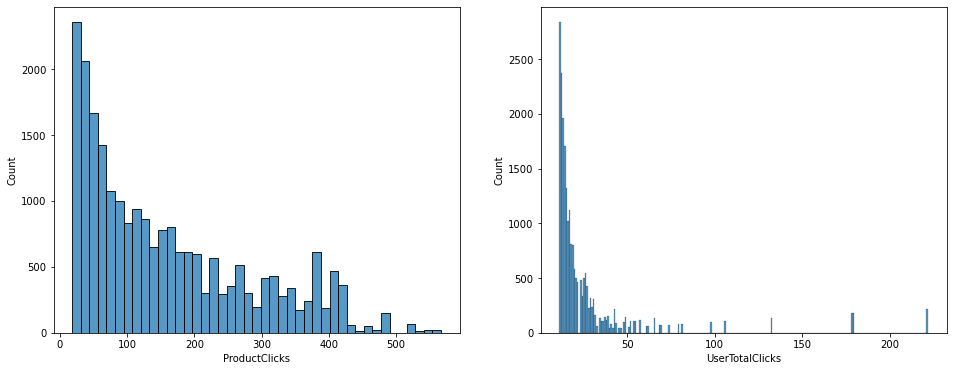

In [190]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
sns.histplot(data = clicks_fr_filtered, x = 'ProductClicks',ax = ax[0])
sns.histplot(data = clicks_fr_filtered, x = 'UserTotalClicks',ax = ax[1])

In [191]:
# params = []
# for min_product in [40,45,50]:
#     for max_product in [0,1,2]:
#         for min_users in [10]:
#             clicks_fr_filtered = clicks_fr[(clicks_fr.ProductClicks > min_product) & (clicks_fr.ProductClicks < (clicks_fr.ProductClicks.mean() + max_product*clicks_fr.ProductClicks.std()))]
#             clicks_fr_filtered['UserTotalClicks'] = clicks_fr_filtered.groupby(by=['UserId'])['OfferId'].transform('count')
#             clicks_fr_filtered = clicks_fr_filtered[((clicks_fr_filtered.UserTotalClicks > 10))]
#             clicks_per_user_product = clicks_fr_filtered.groupby(by=['User','Offer']).count()['UserTotalClicks'].reset_index().rename({'UserTotalClicks':'UserClicks'}, axis = 1)
#             sparse_user_item = csr_matrix((clicks_per_user_product['UserClicks'], (clicks_per_user_product['User'], clicks_per_user_product['Offer'])))
#             train, test, model = als_model()
#             precision = implicit.evaluation.precision_at_k(model, train, test)
#             params.append([min_product, max_product, min_users, precision])
# full_params = pd.DataFrame(params, columns = ['min_product','max_product', 'min_users', 'precision'])

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/572 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/528 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/794 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/470 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/749 [00:00<?, ?it/s]

In [192]:
full_params.sort_values(by='precision',ascending = False)

,min_product,max_product,min_users,precision
4,45,1,10,0.150453
7,50,1,10,0.147472
1,40,1,10,0.140400
8,50,2,10,0.136476
5,45,2,10,0.126070
2,40,2,10,0.117990
0,40,0,10,0.098361
3,45,0,10,0.045455
6,50,0,10,0.000000



### Agrupamento de dos clicks de usuário em ofertas únicas para termos a quantidade de cada usuário em cada oferta.


In [194]:
clicks_per_user_product = clicks_fr_filtered.groupby(by=['User','Offer']).count()['UserTotalClicks'].reset_index().rename({'UserTotalClicks':'UserClicks'}, axis = 1)

### Criação de matrizes esparsas Usuário-item e item-usuário

In [205]:
alpha = 15
sparse_item_user = csr_matrix((clicks_per_user_product['UserClicks'], (clicks_per_user_product['Offer'], clicks_per_user_product['User'])))
sparse_user_item = csr_matrix((clicks_per_user_product['UserClicks'], (clicks_per_user_product['User'], clicks_per_user_product['Offer'])))

sparse_user_item = (sparse_user_item).astype('double') 
data = (sparse_item_user).astype('double')

In [207]:
#Esparsidade de matriz
possible_interactions = sparse_item_user.shape[0]*sparse_item_user.shape[1]
interacted = len(sparse_item_user.nonzero()[0])
sparsity = 1 - interacted/possible_interactions
sparsity

0.999999941955593

 Mais de 99.99% das interações possíveis entre usuários e produtos na atual base dados não foi ainda realizada. Segundo artigo: For collaborative filtering to work, the maximum sparsity you could get away with would probably be about 99.5% or so. Devemos reavaliar a matriz?

In [208]:
save_npz(os.getcwd()+"/.npz/fr/sparse_user_item.npz", sparse_user_item)
save_npz(os.getcwd()+"/.npz/fr/sparse_item_user.npz", sparse_item_user)

In [209]:
model_path = os.getcwd()+'/.pkl/fr/fr_als_model.pkl'

* Criação de diferentes matrizes esparsas para operar com o algoritmo. Usuário-item e item-usuário. Cada uma deve ser usada no momento preciso
* O alfa é o coeficiente de confiabilidade da interação do usuário com um item específico. Valor utilizado fi adotado com base no artigo: https://towardsdatascience.com/alternating-least-square-for-implicit-dataset-with-code-8e7999277f4b. Mas, podemos testar outros valores na validação do modelo.
* Outro artigo de base pra elaboração do modelo: https://medium.com/analytics-vidhya/implementation-of-a-movies-recommender-from-implicit-feedback-6a810de173ac

# FUNÇÃO DE RECOMENDAÇÕES - IMPLICIT

## Treinamento de modelos

In [210]:
#offers = pickle.load(open(os.getcwd()+"/.pkl/offers.pkl", "rb"))

Carregamentodo dicionário que converte os códigos de ofertas para o seu título de oferta. Ainda falta traduzir do alemão para o inglês para tirar mais significado dos resultados

In [215]:
def als_model():
    
    '''computes p@k and map@k evaluation metrics and saves model'''
    
    #sparse_item_user = load_npz(os.getcwd()+"/.npz/sparse_item_user.npz")
      
    train, test = implicit.evaluation.train_test_split(sparse_user_item, train_percentage=0.8)

    model = implicit.als.AlternatingLeastSquares(factors=10, 
                                                 regularization=0.5, 
                                                 iterations=50,
                                                 calculate_training_loss=False)
    alpha=15
    model.fit(train*alpha)

    with open(model_path, 'wb') as pickle_out:
        pickle.dump(model, pickle_out)
    
    return train, test, model

In [216]:
train, test, model = als_model()
implicit.evaluation.precision_at_k(model,train,test)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/726 [00:00<?, ?it/s]

0.12564991334488734

* Sobre metricas de precisão @k: https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54
* Sobre NDCG: https://towardsdatascience.com/evaluate-your-recommendation-engine-using-ndcg-759a851452d1
* Sobre Mean Average Precision: https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52

Ainda não foi realizada qualquer tunagem de hiperaparâmetros. Podemos pegar alguns valores de referencia para rodar um gridsearch

* A matriz m passa a ser a matriz com o novo usuário atualizado e é levada em consideração no para o cálculo de novos vetores.

Nota: 
* Após os ajustes na organização das matrizes esparsas, o modelo parece não mais repetir recomendações de itens que já foram clicados pelo usuário
* O modelo parece também não mais necessitar de tradução dos códigos de ofertas e usuário adotados na matriz esparsa para os códigos da matriz original

### Criação e armazenamento do dicionário código-titulo de oferta (carregado na parte de cima do código).

In [226]:
offers_fr = dict(zip(df_temp['Offer'], df_temp['OfferTitle']))

In [227]:
#dic = pd.read_csv('de_traduzido.csv')
#dic['Offer2'] = dic['OfferTitle'].map(dict(zip(clicks_fr.OfferTitle, clicks_fr.Offer)))

In [228]:
pickle.dump(offers_fr, open('.pkl/fr/offers_fr.pkl', 'wb'))

### Criação e armazenamento do dicionário código_oferta -> Filha_1 e código_oferta -> Categoria (carregado na parte de cima do código).

In [229]:
clicks_fr.filha_1 = clicks_fr.filha_1.astype('int32')

In [230]:
df_temp = clicks_fr[['Offer','filha_1', 'Category']]

In [231]:
df_temp = df_temp.drop_duplicates(['Offer','filha_1', 'Category'])

In [232]:
offer_filha1 = dict(zip(df_temp['Offer'], df_temp['filha_1']))
pickle.dump(offer_filha1, open('.pkl/fr/offer_sub1.pkl', 'wb'))

In [233]:
offer_cat = dict(zip(df_temp['Offer'], df_temp['Category']))
pickle.dump(offer_filha1, open('.pkl/fr/offer_cat.pkl', 'wb'))

### Tabela de info dos produtos

In [234]:
products_info = clicks_fr[['Offer','Category','filha_1', 'ProductClicks']]

In [235]:
products_info.filha_1 = products_info.filha_1.astype('int32')

In [236]:
products_info = products_info.drop_duplicates().reset_index().drop('index', axis = 1)

In [237]:
products_info.rename({'filha_1':'SuperCat'}, axis = 1, inplace = True)

In [238]:
products_info.sort_values(by=['SuperCat','ProductClicks'], ascending = False, inplace = True)

In [242]:
products_info.to_csv('.csv/fr/products_info.csv')

In [243]:
products_info.head()

,Offer,Category,SuperCat,ProductClicks
119765,197556,100513123,100450123,406
305519,44911,100508723,100450123,391
127018,45255,100334923,100450123,373
126916,70579,100334923,100450123,333
238397,225605,100450223,100450123,284


### Dicionário Nome Sub1

In [109]:
df = clicks_fr[['filha_1','filha_1_name']].drop_duplicates()
sub1_name = dict(zip(df.filha_1, df.filha_1_name))
pickle.dump(sub1_name, open('.pkl/sub1_name.pkl', 'wb'))
sub1_name[100471423]

'Entertainment'

### Dicionário Nome Cat

In [110]:
df = clicks_fr[['Category','Translate']].drop_duplicates()
cat_name = dict(zip(df.Category, df.Translate))
pickle.dump(cat_name, open('.pkl/cat_name.pkl', 'wb'))
cat_name[6513]

'Video Games'

## Tunagem de hiperparametros

In [26]:
grid = {'factors': [10,50,100,200],
       'regularization':[1,0.5, 0.1, 0.01],
        'iterations':[10,30,50, 100], 
        'alphas':[1,15,40,60, 100]}

In [27]:
model = implicit.als.AlternatingLeastSquares()

In [32]:
def gridsearch_als(grid):
    results = []
    for factor in grid['factors']:
        for regularization in grid['regularization']:
            for iteration in grid['iterations']:
                for alpha in grid['alphas']:
            
                    model = implicit.als.AlternatingLeastSquares(factors = factor, 
                                                                 regularization = regularization, 
                                                                 iterations = iteration)
                    model.fit(train*alpha)

                    partial = model_evaluation(train, test, model)
                    results.append([factor, regularization, iteration, alpha, partial['p@K'],partial['map@K'], partial['ndcg@K'], partial['auc@K']])
                
    final = pd.DataFrame(results, columns = ['Factors','Regularization','Iteration','alpha','P@K','MAP@K','NDCG@K','AUC@K'])
    return final
                

In [33]:
grid_results = gridsearch_als(grid)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [35]:
grid_results.to_csv('params_fr.csv')

In [34]:
grid_results.sort_values(by=['P@K','NDCG@K'], ascending = False)

,Factors,Regularization,Iteration,alpha,P@K,MAP@K,NDCG@K,AUC@K
31,10,0.50,50,15,0.121244,0.050360,0.089530,0.562224
71,10,0.01,50,15,0.120196,0.045793,0.085133,0.563239
141,50,0.01,10,15,0.119846,0.046794,0.085098,0.563999
61,10,0.01,10,15,0.119497,0.048588,0.087287,0.561895
46,10,0.10,30,15,0.118798,0.047430,0.086641,0.562528
...,...,...,...,...,...,...,...,...
277,200,0.50,100,40,0.079315,0.031223,0.057980,0.544059
288,200,0.10,30,60,0.078616,0.031024,0.057116,0.543346
273,200,0.50,50,60,0.078267,0.030822,0.056945,0.543087
312,200,0.01,50,40,0.077918,0.031056,0.056749,0.542580
